In [1]:
# !pip install torchmetrics torchvision
# !pip install tensorboard==2.10.1
# !pip install pytorch-lightning

import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from PIL import Image

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.models import resnet18
import pytorch_lightning as pl

from tqdm import tqdm

# torch.cuda.init()
# assert torch.cuda.is_initialized()
# print(torch.cuda.get_device_properties(0))

BRCA_ROOT = "/home/ngsci/datasets/brca-psj-path/"
IMAGE_ROOT = os.path.join(BRCA_ROOT, "basic-downsampling/v2/")
LOGGER_DIR = "/home/ngsci/logs"

## 0. Load Data and Inspect

In [2]:
# goal: create slide_id : cancer stage mapping
slide_biop_df = pd.read_csv(
    "/home/ngsci/datasets/brca-psj-path/v2/slide-biopsy-map.csv"
)
outcomes_df = pd.read_csv("/home/ngsci/datasets/brca-psj-path/v2/outcomes.csv")
slide_stage_df = slide_biop_df.merge(outcomes_df, on="biopsy_id")

# map cancer stage to 0 - 4:
# outcomes_df["stage"].unique()
#     ['IA', 'IIB', 'IIA', '0', nan, 'IIIC', 'IV', 'IIIA', 'IIIB', 'IB']
def stage_to_int(stage):
    if stage == "0":
        return 0
    elif stage == "IA" or stage == "IB":
        return 1
    elif stage == "IIA" or stage == "IIB":
        return 2
    elif stage == "IIIA" or stage == "IIIB" or stage == "IIIC":
        return 3
    elif stage == "IV":
        return 4
    else:
        return np.nan


slide_stage_df["stage"] = slide_stage_df["stage"].apply(stage_to_int)

# subset columns, drop nans, reset index
labels_df = (
    slide_stage_df[["slide_id", "biopsy_id", "stage"]]
    .copy()
    .dropna(how="any")
    .reset_index(drop=True)
)
labels_df["stage"] = labels_df["stage"].astype(int)

labels_df.head(5)

,slide_id,biopsy_id,stage
0,6ab0f66f-4940-422a-8228-35a35898b95a,648c5df3-c7ad-47dc-9173-2985276e0b14,1
1,9f53981d-1fde-43c9-982b-d9b2bc87bc0d,648c5df3-c7ad-47dc-9173-2985276e0b14,1
2,4d398be8-3ac8-4327-aab6-5d72bc3c7c56,648c5df3-c7ad-47dc-9173-2985276e0b14,1
3,76da33f3-fa63-4daa-a4f6-835dfe695f39,52e91bc1-6536-461e-b463-34687836ef0f,1
4,499ca705-46d1-4907-ac67-51ff52505169,52e91bc1-6536-461e-b463-34687836ef0f,1


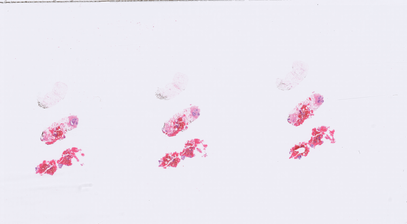

In [3]:
# split train and test set
def random_split(df, val_size):
    """helper function to split training and test sets"""
    n = len(df)
    idxs = np.random.randint(0, n, size=val_size)
    test_df = df.iloc[idxs].copy().reset_index(drop=True)
    train_df = df.drop(index=idxs).reset_index(drop=True)

    return train_df, test_df


train_df, test_df = random_split(labels_df, 1000)

# inspect image
def get_image(idx, df, numpy=False, to_float=False):
    """helper function to fetch image from disk"""
    path = os.path.join(IMAGE_ROOT, df.loc[idx, "slide_id"] + ".png")
    assert os.path.exists(path)

    img = Image.open(path)
    if numpy:
        arr = np.asarray(img)
        if to_float:
            arr = arr / 255.0
        return arr
    else:
        return img


img = get_image(2, train_df)
img

In [4]:
# compute means and stds for normalization

means = []
stds = []
for idx in range(100):
    arr = get_image(idx, train_df, numpy=True, to_float=True)
    means.append(arr.mean(axis=(0, 1)))
    stds.append(arr.std(axis=(0, 1)))

MEANS = np.vstack(means).mean(axis=0)
STDS = np.vstack(stds).mean(axis=0)

print(MEANS, STDS)

[0.92740107 0.90446373 0.94529596] [0.02340832 0.06800389 0.04525188]


## 1. Create Dataset and DataLoader

In [5]:
# PyTorch requires two things:
# 1. Dataset (wrapper around Pandas-style Dataframe):
#    a. implements __len__
#    b. implements __getitem__
#    c. returns *single tuple* of (image, label)
# 2. DataLoader (see below)


class BiopsyDataset(Dataset):
    """Implements two functions: __len__ and __getitem__"""

    def __init__(self, df, transform=None, train=True):
        self.df = df
        self.transform = transform
        self.train = train

        if self.train:
            self.train = self.df.sample(frac=1.0, ignore_index=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = get_image(idx, self.df, numpy=True, to_float=True)
        label = int(self.df.loc[idx, "stage"])

        if self.transform:
            img = self.transform(img)

        return img, label

In [6]:
# Pytorch DataLoaders are created as methods in Lightning DataModule class:
# 1. train_dataloader returns DataLoader for training dataset
# 2. test_dataloader returns DataLoader for test dataset
# 3. Image transformation happens at the DataLoader level,
#       but called within Dataset (inherited from torch.Dataset)


class BiopsyDataModule(pl.LightningDataModule):
    """Returns training and test data from datasets in batches of given size"""

    def __init__(self, df, batch_size=64, num_workers=8):
        super().__init__()
        self.full_df = df
        self.batch_size = batch_size
        self.num_workers = num_workers

        # note transformations: cast to Tensor, Resize, Normalize
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Resize((224, 224)),
                transforms.Normalize(MEANS, STDS),
            ]
        )

        self.setup()

    def setup(self, stage=None):
        if stage == "train" or stage == None:
            self.train_df, self.test_df = random_split(self.full_df, 1000)
        else:
            pass

    def train_dataloader(self):
        return DataLoader(
            BiopsyDataset(self.train_df, transform=self.transform),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            BiopsyDataset(self.test_df, transform=self.transform),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
        )

## 2. Create Module (Network Architecture)

In [7]:
# create LightningModule that defines network architecture:
# 1. Need forward, training_step, test_step, configure_optimizer methods


class BiopsyModel(pl.LightningModule):
    """Defines deep learning model (resnet) and implements forward,
    training_step, test_step, and configure_optimizers"""

    def __init__(self, learning_rate=1e-3, num_classes=5):
        super().__init__()

        self.lr = learning_rate
        self.num_classes = num_classes

        self.net = resnet18(pretrained=False, num_classes=self.num_classes)
        self.net.double()

        self.test_accuracy = Accuracy()

    def forward(self, X):
        return self.net.forward(X)

    def training_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self.net.forward(imgs)
        loss = nn.functional.cross_entropy(logits, labels)

        self.log("train_loss", loss)

        return loss

    def test_step(self, batch, batch_idx):
        imgs, labels = batch
        logits = self.net.forward(imgs)
        loss = nn.functional.nll_loss(logits, labels)

        preds = torch.argmax(logits, dim=-1)
        self.test_accuracy.update(preds, labels)
        self.log("test_acc", self.test_accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

## 3. Train Model

In [8]:
# The easy part! Train our model.
# Pytorch Lightning saves logs and parameters in specified directory
# note: change LOGGER_DIR at the top to change location of logs

data = BiopsyDataModule(labels_df)
model = BiopsyModel()
logger = pl.loggers.CSVLogger(save_dir=LOGGER_DIR, name="biopsy_demo")

# note: change max steps and epochs! (step = 1 step of gradient descent, i.e. one batch; epoch = 1 pass over entire dataset)
# accelerator="auto" will utilize a gpu if it is available
trainer = pl.Trainer(
    accelerator="auto", devices=1, max_steps=10, max_epochs=1, logger=logger
)

# train model on training data
trainer.fit(model, data)

# test model on test data
trainer.test(model, data)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | net           | ResNet   | 11.2 M
1 | test_accuracy | Accuracy | 0     
-------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.716    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_steps=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.24799999594688416
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_acc': 0.24799999594688416}]

In [9]:
# inspect class distribution

data.test_df["stage"].value_counts().sort_index() / data.test_df["stage"].count()

0    0.178
1    0.511
2    0.233
3    0.065
4    0.013
Name: stage, dtype: float64